<a href="https://colab.research.google.com/github/LeMagnifiq/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import pandas as pd
import datetime
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

## Dataset

In [2]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"

response = requests.get(url)

with open("online_retail_II.xlsx", 'wb') as f:
    f.write(response.content)


In [3]:
# Load the dataset
df = pd.read_excel('online_retail_II.xlsx')

In [4]:
# Drop rows with missing descriptions
df = df.dropna(subset=['Description'])

# Convert 'Invoice' column to string type
df = df.copy()
df['Invoice'] = df['Invoice'].astype(str)


# Drop the rows with cancellations
df = df[~df['Invoice'].str.contains('C')]

In [5]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

## Data Preprocessing and Transaction Encoding

In [6]:
# Convert 'Description' column to string type
df['Description'] = df['Description'].astype(str)

# Convert the data to a list of lists for transaction encoding
transactions = df.groupby(['Invoice'])['Description'].apply(list).tolist()

# Use the TransactionEncoder from mlxtend to transform our data
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)

# Convert the encoded array to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.columns_)


<ipython-input-6-90ac340eaf79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str)


## Frequent Itemsets Generation

In [7]:
# Use the apriori function to find frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)

## Association Rules Mining

In [8]:
# Generate the association rules - by default, this generates rules with a minimum lift of 1
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
# Sort rules by the lift metric
rules = rules.sort_values('lift', ascending=False)

In [9]:
# Print out the top rules
print(rules.head())

                         antecedents                      consequents  \
31      (CHILDS GARDEN TROWEL BLUE )      (CHILDS GARDEN TROWEL PINK)   
30       (CHILDS GARDEN TROWEL PINK)     (CHILDS GARDEN TROWEL BLUE )   
101     (POPPY'S PLAYHOUSE BEDROOM )  (POPPY'S PLAYHOUSE LIVINGROOM )   
100  (POPPY'S PLAYHOUSE LIVINGROOM )     (POPPY'S PLAYHOUSE BEDROOM )   
102      (POPPY'S PLAYHOUSE KITCHEN)  (POPPY'S PLAYHOUSE LIVINGROOM )   

     antecedent support  consequent support   support  confidence       lift  \
31             0.012068            0.012631  0.010002    0.828794  65.613354   
30             0.012631            0.012068  0.010002    0.791822  65.613354   
101            0.014932            0.012256  0.010518    0.704403  57.474927   
100            0.012256            0.014932  0.010518    0.858238  57.474927   
102            0.016059            0.012256  0.010988    0.684211  55.827385   

     leverage  conviction  
31   0.009849    5.767130  
30   0.009849    4.74560

## Churn Prediction

### Data Preprocessing

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## Feature Engineering

### Creating RFM Features

In [11]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1) # The latest date in the data set will be used as a snapshot_date.

# Aggregate data on a customer level
customers = df.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'Price': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'Invoice': 'Frequency',
                            'Price': 'MonetaryValue'}, inplace=True)

# Churn label
customers['Churn'] = customers['Recency'].apply(lambda x: 1 if x > 90 else 0)


### Label Creation - Churned Customers

In [12]:
customers['Churn'] = customers['Recency'].apply(lambda x: 1 if x > 90 else 0)

## Exploratory Data Analysis (EDA)

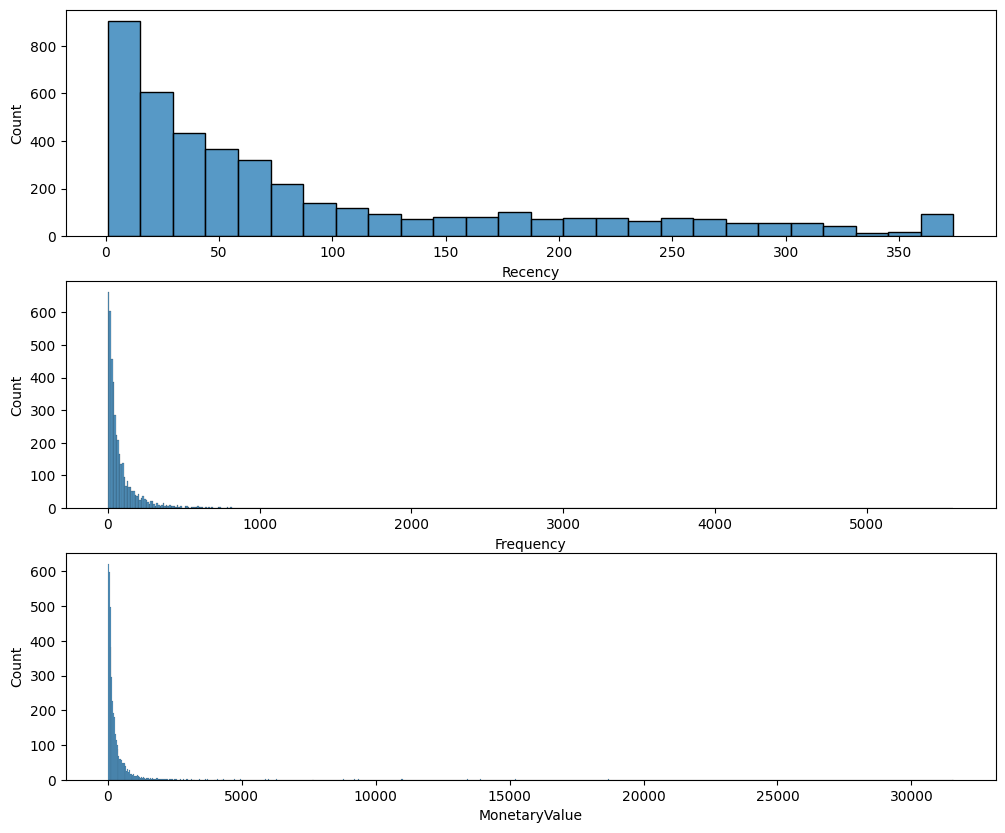

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of Recency, Frequency, and MonetaryValue
plt.figure(figsize=(12,10))

# Recency
plt.subplot(3, 1, 1)
sns.histplot(customers['Recency'])

# Frequency
plt.subplot(3, 1, 2)
sns.histplot(customers['Frequency'])

# MonetaryValue
plt.subplot(3, 1, 3)
sns.histplot(customers['MonetaryValue'])

plt.show()


In [14]:
# Summary statistics
print(customers.describe())

           Recency    Frequency  MonetaryValue        Churn
count  4314.000000  4314.000000    4314.000000  4314.000000
mean     91.269124    94.505100     311.317521     0.333102
std      96.943482   202.020116     863.653402     0.471377
min       1.000000     1.000000       0.000000     0.000000
25%      18.000000    18.000000      56.877500     0.000000
50%      53.000000    44.000000     136.760000     0.000000
75%     136.000000   102.000000     322.765000     1.000000
max     374.000000  5570.000000   31567.340000     1.000000


In [15]:
# Churn distribution
print(customers['Churn'].value_counts())

0    2877
1    1437
Name: Churn, dtype: int64


In [16]:
print(customers.columns)

Index(['Recency', 'Frequency', 'MonetaryValue', 'Churn'], dtype='object')


## Key Insights

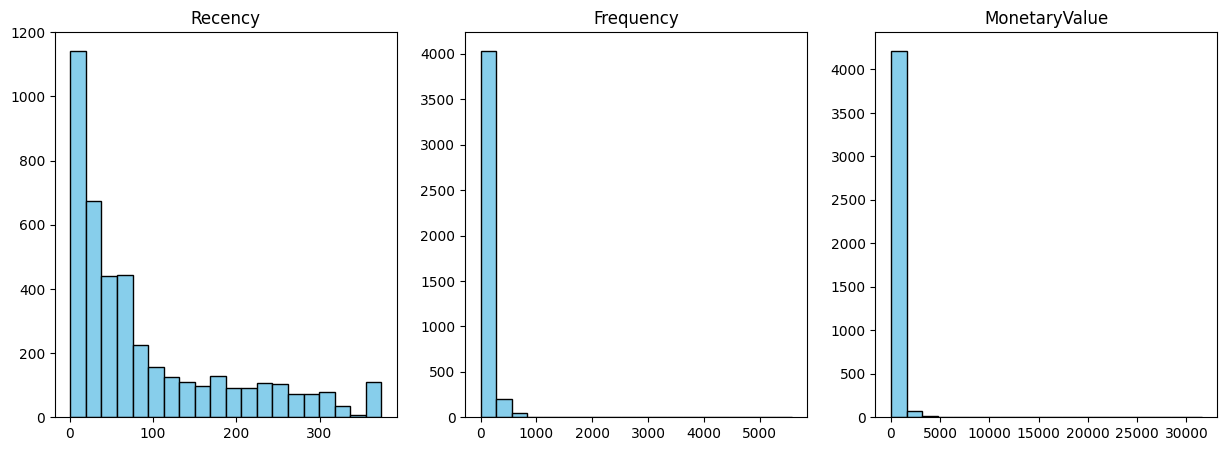

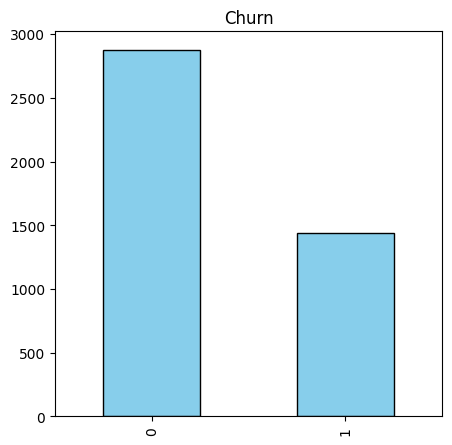

In [17]:
import matplotlib.pyplot as plt

# Histograms for Recency, Frequency, and MonetaryValue
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(customers['Recency'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Recency')
ax[1].hist(customers['Frequency'], bins=20, color='skyblue', edgecolor='black')
ax[1].set_title('Frequency')
ax[2].hist(customers['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
ax[2].set_title('MonetaryValue')
plt.show()

# Bar plot for Churn
plt.figure(figsize=(5,5))
customers['Churn'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn')
plt.show()


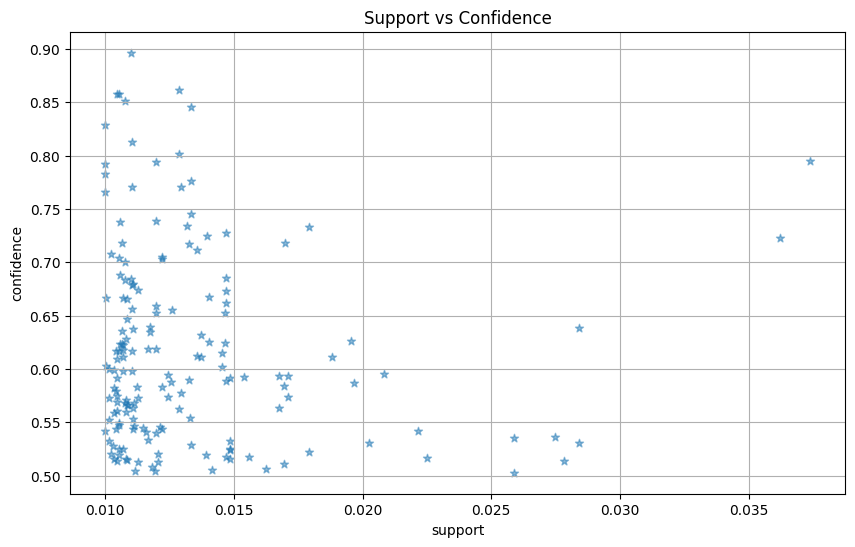

In [18]:
# Scatter plot for support vs confidence
plt.figure(figsize=(10,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, marker='*')
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.grid()
plt.show()


## Data Preprocessing for Machine Learning

In [19]:
# Convert 'Churn' to integer type
customers['Churn'] = customers['Churn'].astype('int')


## Data Split

In [20]:
# Define the feature variables and the target variable
X = customers[['Recency', 'Frequency', 'MonetaryValue']]
y = customers['Churn']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Scaling

In [21]:
# Normalize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Selection

### Logistic Regression

In [22]:
# Initialize the model

logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

## Model Evaluation

In [23]:
#Metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.9953650057937428
Precision: 1.0
Recall: 0.9862068965517241
F1 Score: 0.9930555555555556


In [24]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)


[[573   0]
 [  4 286]]
